In [1]:
## Install tensorflow_addons
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.9 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/MVNet_Fin/'
os.chdir(drive_path)
os.getcwd() 

Mounted at /content/drive


'/content/drive/My Drive/MVNet_Fin'

In [3]:
## Load useful packages
import os
import pandas as pd
import numpy as np
from numpy.random import sample
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, ConvLSTM1D, Add
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization

from scipy.io import savemat
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
lab_codes = ['P18','P13','P08','P04','P01']

input_dt = pd.read_csv('/content/drive/My Drive/MVNet_Fin/mvnet_input_LOESS.csv')
label_dt = pd.read_csv('/content/drive/My Drive/MVNet_Fin/mvnet_label_LOESS.csv')

print('Checking uniqueness of Input and Label data')
Num_entr = np.unique(np.mean(np.asarray(input_dt.iloc[:,3:4]),axis=1)).shape[0]
Num_conc = np.unique(np.mean(np.asarray(label_dt.iloc[:,3:4]),axis=1)).shape[0]
print('Number of unique measurement entries: ', Num_entr)
print('Number of unique concentrations: ', Num_conc)

Checking uniqueness of Input and Label data
Number of unique measurement entries:  675
Number of unique concentrations:  14


In [5]:
max(label_dt.iloc[:,3:].max())


1.0

In [6]:
def extract_train_test_data(input_dt, label_dt, test_lab_idx):
  valid_lab_index = np.random.choice(4,1)
  lab_IDs=input_dt.iloc[:,0].unique()
  num_labs = lab_IDs.shape[0]

  test_lab_ID =lab_IDs[test_lab_idx]
  remain_labs = np.squeeze(lab_IDs[np.argwhere(np.asarray(lab_IDs)!=test_lab_ID)])
  valid_lab_ID = remain_labs[valid_lab_index]
  train_lab_IDs = np.squeeze(remain_labs[np.argwhere(np.asarray(remain_labs)!=valid_lab_ID)])

  test_indices = np.squeeze(np.argwhere(np.asarray(input_dt.iloc[:,0])==test_lab_ID))
  valid_indices = np.squeeze(np.argwhere(np.asarray(input_dt.iloc[:,0])==valid_lab_ID))
  train_indices = np.squeeze(np.argwhere((np.asarray(input_dt.iloc[:,0])!=valid_lab_ID)&(np.asarray(input_dt.iloc[:,0])!=test_lab_ID)))

  # skip 0~2 & last because 1st is sample_code, 2nd is concentration level, 3rd train/blank/test index and last is labID
  train_data = input_dt.iloc[train_indices,3:]
  train_label = label_dt.iloc[train_indices,3:]
  train_label_con =  input_dt.iloc[train_indices,2]
  train_X_LabConVec = input_dt.iloc[train_indices,[1,0]]

  valid_data = input_dt.iloc[valid_indices,3:]
  valid_label = label_dt.iloc[valid_indices,3:] 
  valid_label_con = input_dt.iloc[valid_indices,2] 
  valid_X_LabConVec = input_dt.iloc[valid_indices,[1,0]]

  test_data = input_dt.iloc[test_indices,3:]
  test_label = label_dt.iloc[test_indices,3:] 
  test_label_con = input_dt.iloc[test_indices,2] 
  test_X_LabConVec = input_dt.iloc[test_indices,[1,0]]

  print('Number of Labs = ', num_labs)
  print('Test-lab ID:',test_lab_ID,
        '\nValidation-lab IDs: ',valid_lab_ID,
        '\nTraining-lab IDs: ',train_lab_IDs)
  print('Number of X(samples, attributes) | \t Y(samples, attributes) in test-set =',test_data.shape,test_label.shape,
        '\nNumber of X(samples, attributes) | \t Y(samples, attributes) in validation-set =', valid_data.shape,valid_label.shape,
        '\nNumber of X(samples, attributes) | \t Y(samples, attributes) in training-set =', train_data.shape,train_label.shape)
  return train_data, valid_data, test_data, train_label, valid_label, test_label, train_lab_IDs, valid_lab_ID, test_lab_ID, train_X_LabConVec, train_label_con, valid_X_LabConVec, valid_label_con, test_X_LabConVec, test_label_con

In [7]:
def load_lab_data(test_lab_index):
  [train_dset, valid_dset, test_dset, train_label, valid_label, test_label, train_lab_IDs, valid_lab_ID, test_lab_ID,
    train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec] = extract_train_test_data(input_dt, label_dt, test_lab_index)

  ################################################ --- DIMENSION --- #################################################
  print(20*'--')
  print('train_data_min:\t\t%3.3f\ntrain_data_max:\t\t%3.3f' % (np.min(np.min(train_dset)),np.max(np.max(train_dset))))
  print('train_label_min:\t%3.3f\ntrain_label_max:\t%3.3f' % (np.min(np.min(train_label)),np.max(np.max(train_label))))
  print('train_concentration_min:\t%3.3f\ntrain_concentration_max:\t%3.3f' % (np.min(np.min(train_Y_LabConVec)),np.max(np.max(train_Y_LabConVec))))

  print('valid_data_min:\t\t%3.3f\nvalid_data_max:\t\t%3.3f' % (np.min(np.min(valid_dset)),np.max(np.max(valid_dset))))
  print('valid_label_min:\t%3.3f\nvalid_label_max:\t%3.3f' % (np.min(np.min(valid_label)),np.max(np.max(valid_label))))
  print('valid_concentration_min:\t%3.3f\nvalid_concentration_max:\t%3.3f' % (np.min(np.min(valid_Y_LabConVec)),np.max(np.max(valid_Y_LabConVec))))

  print('test_data_min:\t\t%3.3f\ntest_data_max:\t\t%3.3f' % (np.min(np.min(test_dset)),np.max(np.max(test_dset))))
  print('test_label_min:\t%3.3f\ntest_label_max:\t%3.3f' % (np.min(np.min(test_label)),np.max(np.max(test_label))))
  print('test_concentration_min:\t%3.3f\ntest_concentration_max:\t%3.3f' % (np.min(np.min(test_Y_LabConVec)),np.max(np.max(test_Y_LabConVec))))


  [X_train, y_train] = np.asarray(train_dset), np.asarray(train_label)
  [X_val, y_val] = np.asarray(valid_dset), np.asarray(valid_label)
  [X_test, y_test] = np.asarray(test_dset), np.asarray(test_label)

  print('X_train_shape:\t\t%s' %str(X_train.shape))
  print('X_val_shape:\t\t%s' %str(X_val.shape))
  print('X_test_shape:\t\t%s' %str(X_test.shape))

  print('y_train_shape:\t\t%s' %str(y_train.shape))
  print('y_val_shape:\t\t%s' %str(y_val.shape))
  print('y_test_shape:\t\t%s' %str(y_test.shape))

  print('y_train_Y_LabConVec_shape:\t\t%s' %str(train_Y_LabConVec.shape))
  print('y_val_Y_LabConVec_shape:\t\t%s' %str(valid_Y_LabConVec.shape))
  print('y_test_Y_LabConVec_shape:\t\t%s' %str(test_Y_LabConVec.shape))

  return X_train, X_val, X_test, y_train, y_val, y_test, train_lab_IDs, valid_lab_ID, test_lab_ID, train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec

In [8]:
def plot_PCA_prof(X_ind_test,y_ind_test,y_ind_test_pred,test_lab_ID):
  pca = PCA(n_components=2, whiten='True')
  pca.fit(X_ind_test.squeeze())
  X_ind_test_PCA = pca.transform(X_ind_test.squeeze())
  y_ind_test_PCA = pca.transform(y_ind_test.squeeze())
  y_ind_test_pred_PCA = pca.transform(y_ind_test_pred.squeeze())
  plt.figure(test_lab_index, figsize = (14,12)) # '#2ca02c'

  ##############################################
  plt.figure(test_lab_index, figsize = (14,12)) # '#2ca02c'
  leg_text = []

  NS = X_ind_test.shape[0] # number of test samples
  NC = Num_conc # number of concentrations
  for i in range(0,NC):
    # print(i, range(0 + i*9,9*(i+1)))
    plt.scatter(X_ind_test_PCA[range(0 + i*9,9*(i+1)),0], X_ind_test_PCA[range(0 + i*9,9*(i+1)),1], alpha=0.5*i/NC, c = 'green', s =100+100*i/NC)
    leg_text.append('Input-C'+str(i))

  for i in range(0,NC):
    # print(i, range(0 + i*9,9*(i+1)))
    plt.scatter(y_ind_test_PCA[range(0 + i*9,9*(i+1)),0], y_ind_test_PCA[range(0 + i*9,9*(i+1)),1], alpha=0.5*i/NC, c = 'red', s = 100+100*i/NC)
    leg_text.append('Target-C'+str(i))

  for i in range(0,NC):
    # print(i, range(0 + i*9,9*(i+1)))
    plt.scatter(y_ind_test_pred_PCA[range(0 + i*9,9*(i+1)),0], y_ind_test_pred_PCA[range(0 + i*9,9*(i+1)),1], alpha=0.5*i/NC, c = 'blue', s = 100+100*i/NC)
    leg_text.append('Output-C'+str(i))

  plt.title(test_lab_ID+'PCA_em for Input, Label, and Ouput data (fit->INPUT, transform -> ALL) Model: 1D-Conv')
  plt.legend(leg_text)

In [9]:
def plot_concentrations(y_ind_test,y_ind_test_pred):
  
  ##############################################
  plt.figure(test_lab_index+5, figsize = (14,12)) # '#2ca02c'
  leg_text = []

  plt.plot(y_ind_test)
  leg_text.append('Actual')
  plt.plot(y_ind_test_pred)
  leg_text.append('Prediction')
  plt.legend(leg_text)

In [16]:
## Designing an Auto-Encoder-Classifier model
def MV_Net(input_shape=(417,1)):
    # Encoder Network
    enc_input = Input(shape=(input_shape[0]), name='enc_input')
    enc_l1 = Dense(input_shape[0], activation='relu', name='encoder_layer1')(enc_input)
    enc_l1 = BatchNormalization()(enc_l1)
    enc_l1 = Add()([enc_l1,enc_input])
    enc_l1 = Dense(417, activation='relu', name='encoder_layer2')(enc_l1)
    concentration_output = Dense(1, activation='relu', name='concentration_output')(enc_l1)

    pre_decoder_output1 = Dense(417, activation='relu', name='pre_decoder_1')(enc_l1)
    
    ## decoder Network
    decoder_output = Dense(input_shape[0], activation='relu', name='decoder_output')(pre_decoder_output1)
    model = Model(inputs=[enc_input], outputs=[concentration_output, decoder_output])

    # Compiling model
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss={'concentration_output': 'mean_squared_error', 'decoder_output': 'mean_squared_error'},
                  loss_weights={'concentration_output': 0.01, 'decoder_output': 0.99},
                  metrics=[metrics.mean_squared_error])
    return model

model = MV_Net()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 417)]        0           []                               
                                                                                                  
 encoder_layer1 (Dense)         (None, 417)          174306      ['enc_input[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 417)         1668        ['encoder_layer1[0][0]']         
 rmalization)                                                                                     
                                                                                                  
 add_5 (Add)                    (None, 417)          0           ['batch_normalization_5[0][

Number of Labs =  5
Test-lab ID: P01 
Validation-lab IDs:  ['P08'] 
Training-lab IDs:  ['P04' 'P13' 'P18']
Number of X(samples, attributes) | 	 Y(samples, attributes) in test-set = (135, 417) (135, 417) 
Number of X(samples, attributes) | 	 Y(samples, attributes) in validation-set = (135, 417) (135, 417) 
Number of X(samples, attributes) | 	 Y(samples, attributes) in training-set = (405, 417) (405, 417)
----------------------------------------
train_data_min:		0.000
train_data_max:		1.000
train_label_min:	0.000
train_label_max:	1.000
train_concentration_min:	0.000
train_concentration_max:	9.000
valid_data_min:		0.000
valid_data_max:		1.000
valid_label_min:	0.000
valid_label_max:	1.000
valid_concentration_min:	0.000
valid_concentration_max:	9.000
test_data_min:		0.000
test_data_max:		1.000
test_label_min:	0.000
test_label_max:	1.000
test_concentration_min:	0.000
test_concentration_max:	9.000
X_train_shape:		(405, 417)
X_val_shape:		(135, 417)
X_test_shape:		(135, 417)
y_train_shape:		(4

MSE_y_train_pred: 24.838740268271824 MSE_y_valid_pred: 26.160598872077976 MSE_y_ind_test_pred: 25.71355226164645
SAVE DIRECTORY ALREADY EXIST
270    0.00
271    0.00
272    0.00
273    0.00
274    0.00
       ... 
400    8.87
401    8.87
402    8.87
403    8.87
404    8.87
Name: conc, Length: 135, dtype: float64
SAVING... LOLO_CV_RESULTS_Conc_Loss_LOESS/LOLO_CV_RESULTS_LAB_ID_P08.mat
Number of Labs =  5
Test-lab ID: P13 
Validation-lab IDs:  ['P04'] 
Training-lab IDs:  ['P01' 'P08' 'P18']
Number of X(samples, attributes) | 	 Y(samples, attributes) in test-set = (135, 417) (135, 417) 
Number of X(samples, attributes) | 	 Y(samples, attributes) in validation-set = (135, 417) (135, 417) 
Number of X(samples, attributes) | 	 Y(samples, attributes) in training-set = (405, 417) (405, 417)
----------------------------------------
train_data_min:		0.000
train_data_max:		1.000
train_label_min:	0.000
train_label_max:	1.000
train_concentration_min:	0.000
train_concentration_max:	9.000
valid_data_

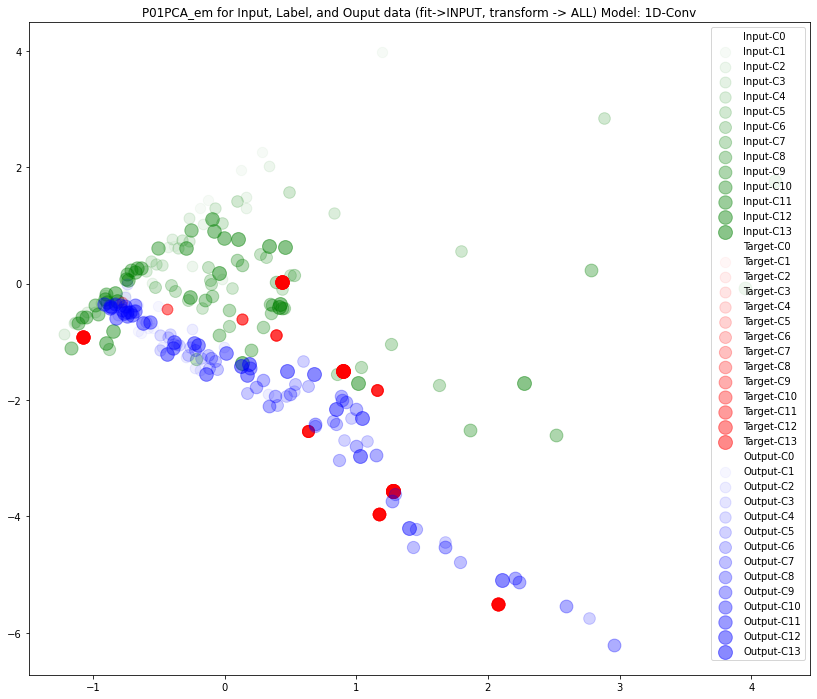

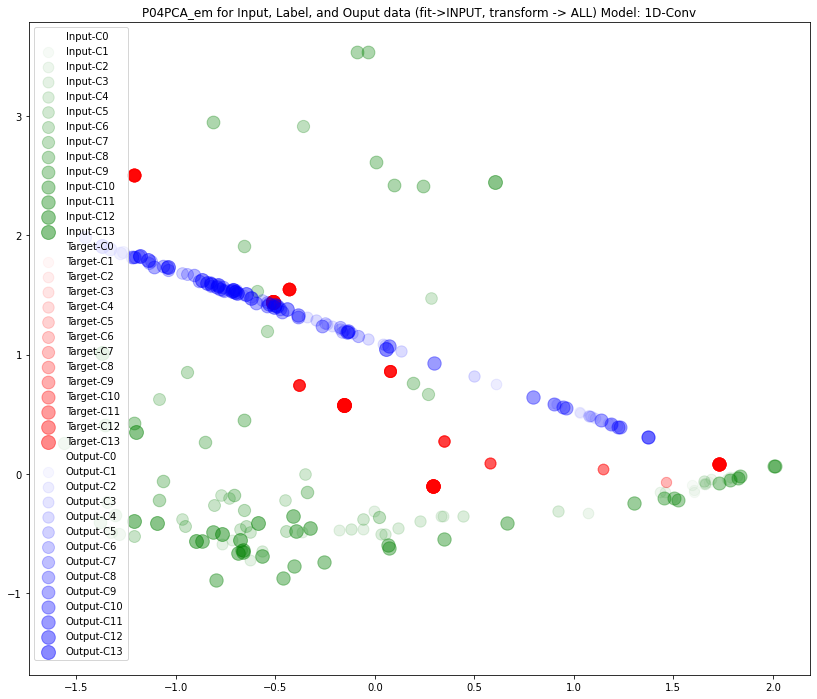

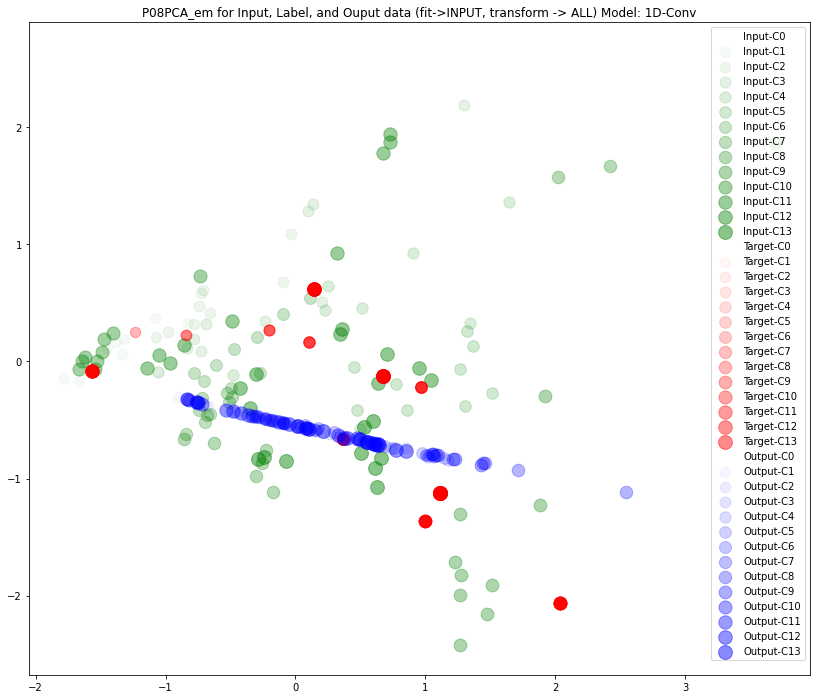

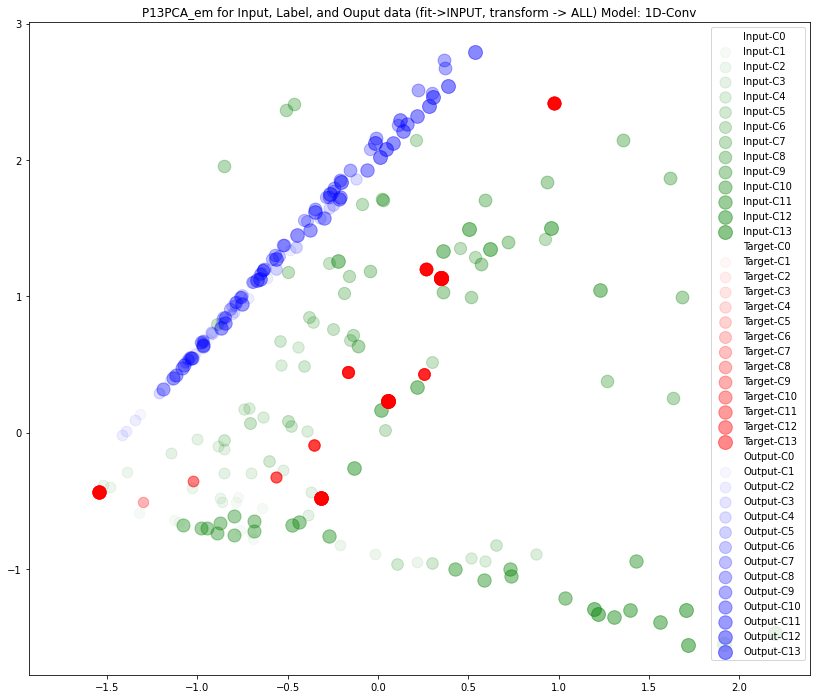

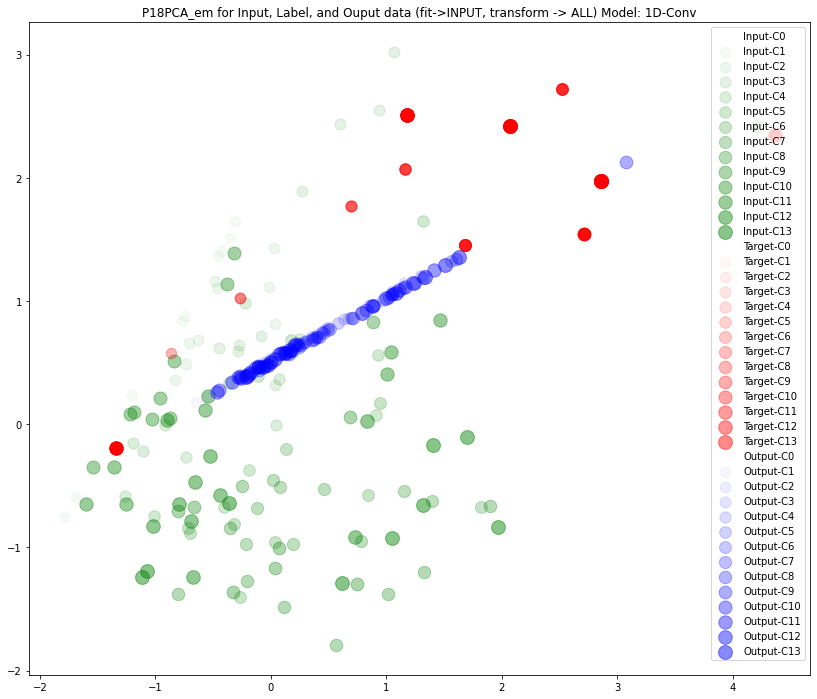

In [17]:
for test_lab_index in range(0,5):
  Stats=[]
  X_train, X_valid, X_ind_test, y_train, y_valid, y_ind_test, train_lab_IDs, valid_lab_ID, test_lab_ID,\
      train_X_LabConVec, train_Y_LabConVec, valid_X_LabConVec, valid_Y_LabConVec, test_X_LabConVec, test_Y_LabConVec = load_lab_data(test_lab_index)

  model = MV_Net()
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
  # es = EarlyStopping(monitor='val_class_output_categorical_accuracy', mode='max', verbose=0, patience=100)
  if not os.path.exists("models"):
    os.mkdir("models")
      
  checkpoint = ModelCheckpoint("./models/model-best_v1.h5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')

  history = model.fit({'enc_input': X_train}, {'concentration_output': train_Y_LabConVec ,'decoder_output': y_train},
                      validation_data = ({'enc_input': X_valid}, {'concentration_output': valid_Y_LabConVec ,'decoder_output': y_valid}),
                      epochs=5000, batch_size=405, callbacks=[checkpoint, es], verbose=0)

  del model  # deletes the existing model
  model = load_model("./models/model-best_v1.h5")

  _, filtered_X_train = model.predict(X_train, batch_size=405, verbose=0)
  MSE_y_train_pred = (np.square(filtered_X_train - y_train)).mean(axis=1)

  _, filtered_X_valid = model.predict(X_valid, batch_size=405, verbose=0)
  MSE_y_val_pred = (np.square(filtered_X_valid - y_valid)).mean(axis=1)

  _, filtered_X_ind_test = model.predict(X_ind_test, batch_size=405, verbose=0)
  MSE_y_ind_test_pred = (np.square(filtered_X_ind_test - y_ind_test)).mean(axis=1)

  Stats.append([-10*np.log10(MSE_y_train_pred.mean()), -10*np.log10(MSE_y_val_pred.mean()), -10*np.log10(MSE_y_ind_test_pred.mean())])
  print('MSE_y_train_pred:', -10*np.log10(MSE_y_train_pred.mean()),
        'MSE_y_valid_pred:', -10*np.log10(MSE_y_val_pred.mean()),
        'MSE_y_ind_test_pred:', -10*np.log10(MSE_y_ind_test_pred.mean()))

  Statistics = np.asarray(Stats)
  plot_PCA_prof(X_ind_test,y_ind_test,filtered_X_ind_test,test_lab_ID)
  #plot_concentrations(np.array(test_Y_LabConVec),y_ind_test_pred)

  save_dir = 'LOLO_CV_RESULTS_Conc_Loss_LOESS'
  if (not(os.path.isdir(save_dir))):
    os.mkdir(save_dir)
    print('CREATING NEW DIRECTORY')
  else:
    print('SAVE DIRECTORY ALREADY EXIST')

  filename = save_dir + '/LOLO_CV_RESULTS_LAB_ID_' + test_lab_ID + '.mat'
  savemat(filename,{'X_train':X_train,'y_train':y_train,'y_train_pred':filtered_X_train,
                    'X_valid':X_valid,'y_valid':y_valid,'y_valid_pred':filtered_X_valid,
                    'X_ind_test':X_ind_test,'y_ind_test':y_ind_test,'y_ind_test_pred':filtered_X_ind_test,
                    'train_lab_IDs':train_lab_IDs,'valid_lab_ID':valid_lab_ID, 'test_lab_ID':test_lab_ID,
                    'train_X_LabConVec':np.asarray(train_X_LabConVec), 'train_Y_LabConVec':np.asarray(train_Y_LabConVec), 'valid_X_LabConVec':np.asarray(valid_X_LabConVec),
                    'valid_Y_LabConVec':np.asarray(valid_Y_LabConVec), 'test_X_LabConVec':np.asarray(test_X_LabConVec), 'test_Y_LabConVec':np.asarray(test_Y_LabConVec)})

  print(test_Y_LabConVec)

  print('SAVING... '+ filename)
  del model  # deletes the existing model